# Setup

Run the following cell to install the necessary dependencies.

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.0 MB/s eta 0:00:00


Run the following cell to import the necessary packages.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost

# Exploratory Data Analysis

Let's classify the sentiment (positive or negative) of movie reviews. For that, we will use the IMDB dataset, which contains 25,000 movie reviews from the Internet Movie Database (IMDB) and their sentiment labels. The dataset comes with the SHAP library.

In [3]:
X, y = shap.datasets.imdb()

Take a look at the dataset (X and y) to get a feeling for the data you are working with.

In [4]:
print(len(X))
print(len(y))

25000
25000


In [5]:
X[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

In [6]:
y

array([False, False, False, ...,  True,  True,  True])

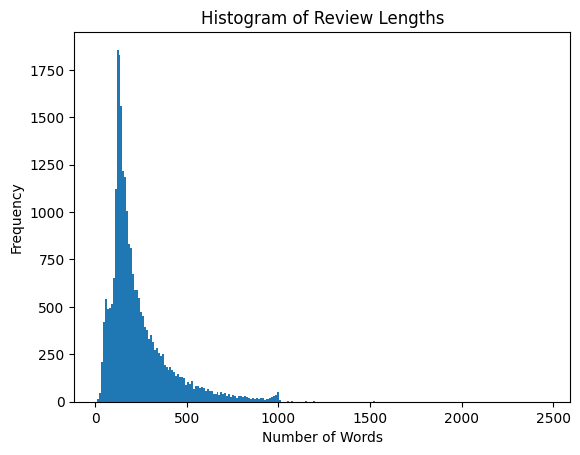

In [7]:
review_lengths = [len(x.split()) for x in X]

plt.hist(review_lengths, bins='auto')
plt.title('Histogram of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Prepare Dataset

Split the data into a training and a test set. Use 20% of the examples for the test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Use TF-IDF representations to convert the text examples into a numeric word-count matrix.

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train).toarray() # .toarray() transforms the sparse matrix into a dense matrix to avoid issues with shap later on
X_test_vec = vectorizer.transform(X_test).toarray()

# Print the dimensions of the resulting TF-IDF matrices
print("Training Set:", X_train_vec.shape)
print("Test Set:", X_test_vec.shape)

Training Set: (20000, 1000)
Test Set: (5000, 1000)


# Remarks about SHAP

*   The `shap` Python package contains **functionality to calculate SHAP values** for several machine learning models
*   As exact SHAP values can be computationally expensive, if not infeasible, to calculate on complex models or large datasets, `shap` implements **several computational improvements and approximation algorithms**
 *   E.g., models are not retrained on every possible feature set. Instead **unknown features are masked or integrated out**
 *   E.g., SHAP values are **approximated through suitable heuristics** (e.g., KernelSHAP) instead of calculated exactly
*   While SHAP values are **model-agnostic in theory**, their implementation in the `shap` Python package **may be model-specific**!
*   The `shap` Python package helps us by **automatically determining suitable approximation strategies** for a particular model and dataset






# SHAP for an XGBoost Model

Instantiate and fit an XGBClassifier model, i.e., a classifier based on decision trees.

In [10]:
model = xgboost.XGBClassifier(random_state=42)
model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Calculate SHAP values using a shap.Explainer object. Then plot the SHAP values in a waterfall chart for a single movie review.

Starting point: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html

Instantiate a **shap.Explainer object** that includes functionality to **approximate SHAP values for a particular model**. The shap.Explainer object automatically chooses an appropriate approximation algorithm based on the model and dataset.

In [11]:
explainer = shap.Explainer(model, X_test_vec, feature_names=vectorizer.get_feature_names_out())

Calculate the SHAP values for all instances in the test dataset at once. For tree-based classifiers such as XGBoost, the algorithm can calculate the SHAP values quite fast.

In [12]:
shap_values = explainer(X_test_vec)

The result is a shap.Explanation object.

In [13]:
type(shap_values)

shap._explanation.Explanation

It encapsulates the SHAP values (.values), dataset average (.base_values), and data from the test dataset (.data).

In [14]:
shap_values

.values =
array([[-0.00467001,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00995523],
       [ 0.00072947,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00920786],
       [ 0.00416186,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00425036],
       ...,
       [-0.00530011,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00875962],
       [-0.00682881,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00920786],
       [-0.00432589,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00436809]])

.base_values =
array([0.03581815, 0.03581815, 0.03581815, ..., 0.03581815, 0.03581815,
       0.03581815])

.data =
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Values are calculated for each test instance and feature, i.e., 5000 instances x 1000 features.

In [15]:
shap_values.shape

(5000, 1000)

Let's look at a particular movie review. We also print its ground truth label and predicted label.

In [16]:
index = 2

print("Review Text:\n", X_test[index])
print(f"Ground Truth: {'POSITIVE' if y_test[index] else 'NEGATIVE'}")
print(f"Model Prediction: {'POSITIVE' if model.predict([X_test_vec[index]])[0] == 1 else 'NEGATIVE'}")

Review Text:
 In the questionable comedy vein of Mel Brooks, "Wholly Moses!" tries to take the Bible story of Moses and make fun of it, resulting in the unfunniest Biblical spoof ever filmed.<br /><br />There is no real plot here, just excuses to trot out stalwart comedy talent in underwritten roles. Dudley Moore and Laraine Newman are on a bus tour of the Holy Land, when they stumble across an ancient scroll in a cave. There they read the story of Herschel and Zerelda, also played by Moore and Newman. Herschel's life parallels Moses'. He was sent down the river to be found by the pharaoh's family at the same time Moses was. Herschel's birth father, the late James Coco, becomes Herschel's slave after Herschel is rescued by idol makers and works as a sculptor. Eventually Herschel comes to work for the pharaoh as an astronomer, is banished, and ends up tending Moses' flock of sheep. Herschel and Moses are brothers in law, marrying sisters, and Herschel thinks God has chosen him to free h

Let's plot a waterfall chart of the SHAP values for that movie review instance.

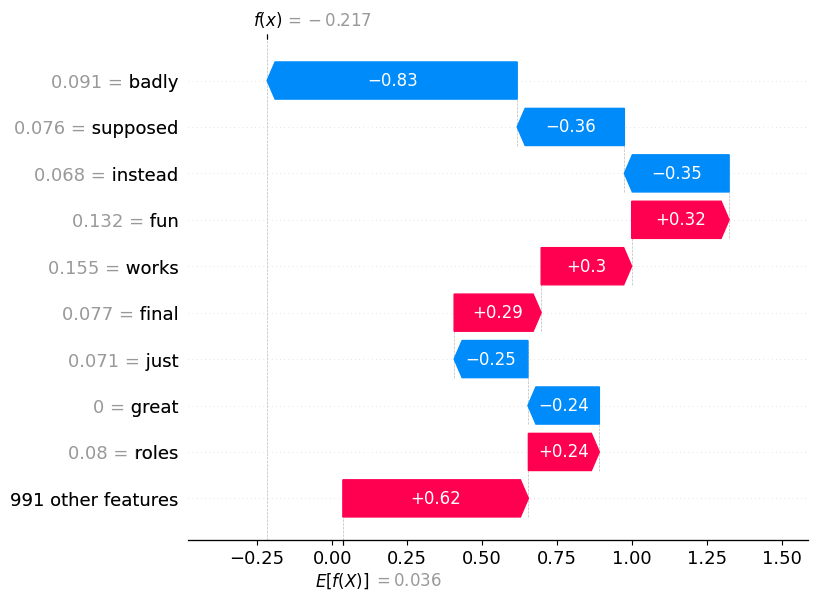

In [17]:
shap.plots.waterfall(shap_values[index])

*   In the chart, we can see the **base value (i.e., dataset average)** at the bottom, the **model's prediction for the instance at the top**, and the **SHAP values for different features** in between.
*   For our **binary classification problem**, SHAP values no longer correspond to a features impact on the prediction value (as in a regression task) but to the **log odds** of belonging to a class

**How are SHAP values different from e.g., feature coefficients in a logistic regression?**

*   SHAP values are **independent of the feature's scale** (e.g., a duration that is measured in minutes instead of seconds would lead to different regression coefficients but not different SHAP values)
*   SHAP values are **local explanations**, i.e., different for each prediction and not constant across all predictions such as regression coefficients



We can also aggregate SHAP values across all explained test instances by taking the **mean of their absolute values**. This gives us a **global explanation of the model**, i.e., an explanation across all instances and not just a single one (local).

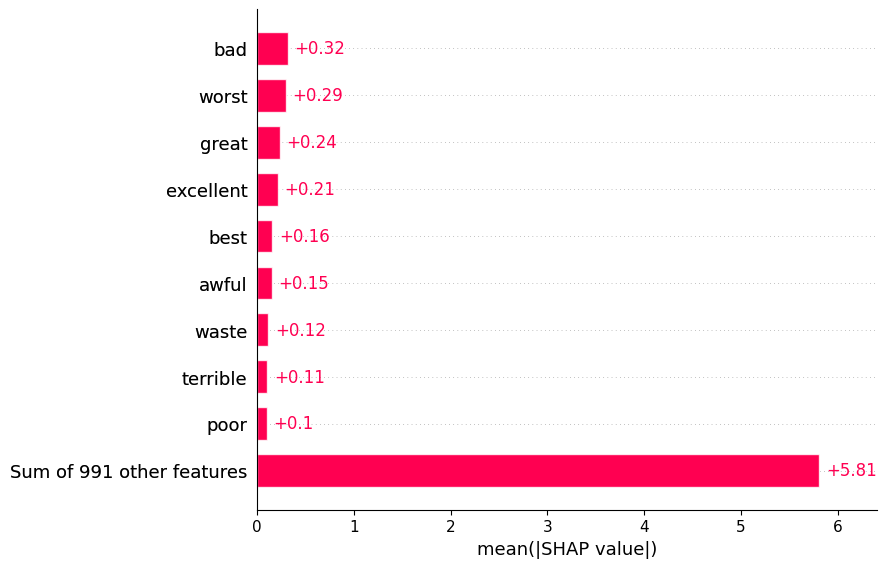

In [18]:
shap.plots.bar(shap_values)

# SHAP for a Transformer-based Model

Now, let's generate SHAP values for a Transformer-based sentiment classifier on the same dataset.

Starting point: https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.html

In [19]:
import transformers

Truncate the reviews to only the first 500 characters to accelerate the computation and avoid exceeding the maximum number of input tokens for our Transformer model.

In [20]:
max_input_length = 500
X_truncated = [x[:max_input_length] for x in X]

Load a pre-configured sentiment classification pipeline.

In [21]:
transformer_model = transformers.pipeline(task='sentiment-analysis', model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', top_k=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Let's predict the sentiment of a single movie review instance. We can see that the pipeline outputs two probability scores, one for 'NEGATIVE' and one for 'POSITIVE' sentiment.

In [22]:
index = 0
transformer_model(X_truncated[index])

[[{'label': 'NEGATIVE', 'score': 0.9932447075843811},
  {'label': 'POSITIVE', 'score': 0.006755329202860594}]]

Instantiate another shap.Explainer object for the Transformer-based pipeline.

In [23]:
explainer = shap.Explainer(transformer_model)

Due to the long processing times for this model type, let's only calculate SHAP values for a single movie review instance this time.

In [24]:
shap_values = explainer([X_truncated[index]])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:48, 108.87s/it]              


For text data, the shap package offers another type of visualization that is interactive.

In [25]:
shap.plots.text(shap_values)

Of course, we can still plot a waterfall chart as before. However, for our Transformer-based pipeline, we must choose whether we want to plot it for the 'NEGATIVE' or the 'POSITIVE' prediction head of our Transformer-based pipeline.

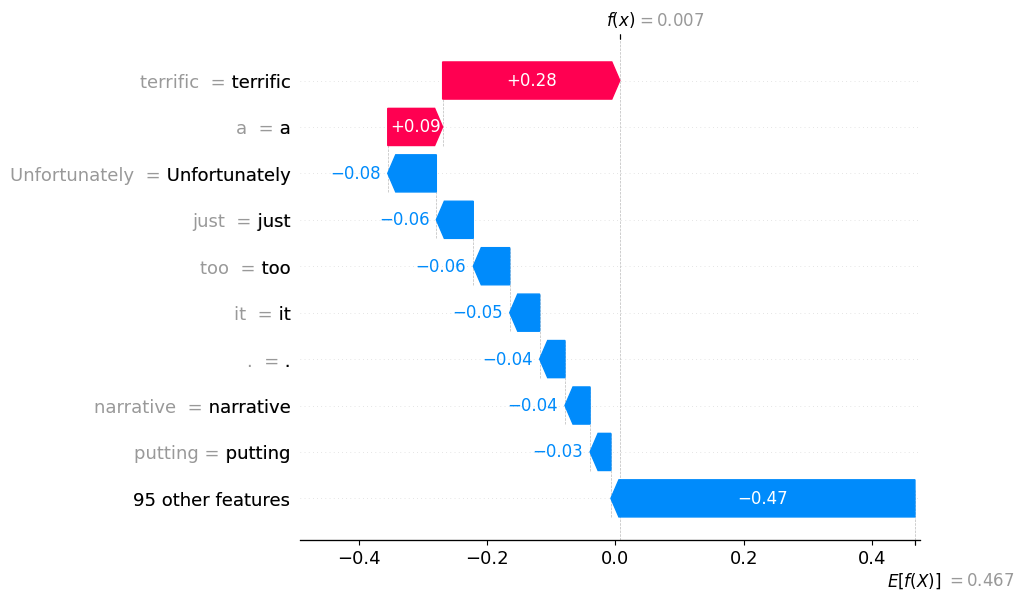

In [26]:
shap.plots.waterfall(shap_values[0,:,'POSITIVE'])

# Practice Questions

### 1. Why are LLMs sometimes bad at solving multi-step reasoning problems? In general, how can we improve the performance of LLM-based problem-solving approaches on multi-step reasoning problems?

**Why are they bad?**

*   LLMs are trained to **predict the next token** in a text sequence based on the previous tokens
*   This is a **linear greedy decoding strategy**, which can limit LLMs in their ability to look ahead and plan longer sequences of multiple steps reliably
*   Sometimes, LLMs choose a next token (or sequence of tokens) that seems appropriate to the LLM at the time it is generated (i.e., high estimated probability) but turns out to be **not ideal within the longer chain** of tokens or reasoning steps
*   Still, **LLMs treat that token as 'set'** once it is generated and predict the following tokens (or sequence of tokens) conditional on that token being good/correct
*   This can lead to **even more compounding errors** in later steps of a reasoning chain
*   The likelihood of an LLM generating a less ideal token is particularly **high for out-of-domain problems**, i.e., problems different from those the LLM has seen during its training
*   **In short:** LLMs sometimes make mistakes when predicting the next token (or step in a reasoning chain). If they do, they are often unable to correct that mistake, making it impossible to arrive at a correct answer.


**How to improve?**

*   We can **embedd LLMs into planning modules** or refinement strategies
*   Such strategies can improve **(1) local exploration** of possible steps, **(2) global planning and correction** of errors, and **(3) explainability** of the LLM's thought process
*   Examples include **Chain-of-Thought** (CoT), **Tree-of-Thoughts** (ToT), and **Probabilistic Tree-of-Thoughts** (ProbTree)

### 2. What are the advantages and disadvantages of using inherently transparent models? In which situation does it make sense, in which situations not?

*   Inherently transparent models are **directly explainable** (e.g., Linear/Logistic Regression, Decision Trees)
*   They are usually so **simple** that we can **immediately understand** how they make their predictions
*   Therefore, transparent models are often considered the **safest and most trustworthy models** in high-stakes domains
*   The main disadvantage is their often **significantly lower accuracy/prediction performance** when compared to state-of-the-art black-box models such as LLMs
*   When we can achieve a reasonably high accuracy with transparent models, or if safety and transparency have the highest priority, we should consider using transparent models, otherwise black-box state-of-the-art models



### 3. How can we make LLMs produce a chain of reasoning steps to solve a complex problem through prompting alone, i.e., without fine-tuning the model?

We can use **Chain-of-Thought (CoT)** or more advanced prompting strategies. CoT can be elicited through demonstration or instruction:

**Chain-of-Thought through demonstration:**

*   Do **few-shot learning**, i.e., include one or more examples of correct input-output pairs with chains of thought in the prompt text
*   Conclude the prompt text with another input that represents the actual problem/question but do not provide the corresponding output
*   The LLM will try to predict the corresponding output with a chain of thought

**Chain-of-Thought through instruction:**

*   If no input-output examples are available or long prompts are too costly, perform **zero-short learning**, i.e., provide no examples
*   Instead, provide instructions on how to answer the question or solve the problem
*   Include an instruction such as **"Let's think step by step"** to make the LLM provide its output divided into a chain of reasoning steps



### 4. How is Tree-of-Thoughts (ToT) different from Chain-of-Thought (CoT) and Input-Output/Standard Prompting (IO)? What kinds of problems can and cannot be solved with each technique?

**Input-Output/Standard Prompting**

*   **Idea:** Provide a question/problem in a prompt. The LLM generates the answer/solution directly
*   **Suitable for:** Simple problems that do not require extended reasoning or exploration of a solution space
*   **Not suitable for:** Complex multi-step reasoning problems, problems that require extended exploration of a solution space, and problems with a discrete and non-differential solution space

**Chain-of-Thought Prompting**

*   **Idea:** Provide examples with a chain-of-thought through few-shot learning or instruct the LLM to "think step by step". The LLM generates a chain of thought
*   **Suitable for:** Complex problems that can be decomposed into a multiple steps
*   **Not suitable for:** Complex multi-step problems that require extended exploration of a solution space and problems with a discrete and non-differential solution space

**Tree-of-Thoughts Prompting**

*   **Idea:** Use multiple specialized prompts (e.g., for thought generation and state evaluation) as part of an overarching tree-based search algorithm that explores solutions to a problem using the LLM's 'creativity' and self-evaluation capabilities
*   **Suitable for:** Highly complex problems that are clearly defined but require advanced search and exploration techniques to find the solution
*   **Not suitable for:** Situations in which the problem is not clearly defined (i.e., we do not have a suitable thought decomposition strategy) or cost-sensitive use cases where we want to minimize the number of prompts and thus inference costs







### 5. When facing a knowledge-related problem or question that is difficult to understand, which LLM prompting technique can help in such cases?

When the problem itself is not clearly stated, no suitable thought decomposition strategy is known, or we must retrieve knowledge from external sources (e.g., the web), **ProbTree** may help to decompose the problem into simpler sub-problems (aka 'understanding' phase) that can be solved through knowledge-based answering (aka 'reasoning' phase).

### 6. When facing a clearly described problem or question where the correct answer is difficult to find, which LLM prompting technique can help in such cases?

When we know how to decompose a problem into individual thoughts, we can use **Tree-of-Thoughts Prompting (ToT)** to explore different possible chains of thought to solve the problem.

### 7. What is the plausibility-faithfulness dilemma in XAI and how can LLM prompting techniques help to avoid or reduce it?

Typo in student worksheet, sorry! Of course it should have been "plausibility-faithfulness dilemma", not "probability-faithfulness dilemma"

*   **Plausibility:** Directed towards humans. Is an explanation plausible? Can we understand it? Does it align with our human rationale?
*   **Faithfulness:** Directed towards the model. Does the explanation reflect the model's actual behavior and thought process?
*   **Dilemma:** Often, plausibility and faithfulness are highly uncorrelated and we can only achieve one at the expense of the other
*   **Possible solution:** Modern prompting techniques can help to improve both, plausibility and faithfulness. Modern LLMs are trained through Reinforcement Learning with Human Feedback (RLHF) and are good at generating plausible explanations as well as using these explanations to improve the accuracy of output generated in the following

